# Pricing by Monte-Carlo

## Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import hyp2f1
from scipy.stats import norm

## Pre-generated probability space
n: number of time split intervals

repeat: number of Monte-Carlo method repetitions

In [9]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

## Black-Scholes Model 

In [10]:
# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf


def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call


def vega_func(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    """

    # calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / sigma * np.sqrt(T)

    # see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call_newton(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    eps = np.finfo(float).eps
    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use newton rapshon to update the estimate
        sigma = sigma - diff / (eps+vega_func(S, K, T, r, sigma))

    return sigma


def implied_volatility_call_bisection(C, S, K, T, r, tol=1e-7, max_iterations=500):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    a = 0
    b = 1
    sigma = 0.5

    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            if black_scholes_call(S, K, T, r, b) < C:
                a = b
                b = 2 * b
            a = sigma
            sigma = 0.5 * (a + b)
        if diff > 0:
            b = sigma
            sigma = 0.5 * (a + b)

    return sigma


def hallerbach_approximation(C, S, K, T, r):

    X = K * np.exp(-r * T)
    sigma = (1 / np.sqrt(T) * np.sqrt(2 * np.pi) / (2 * (S + X))) * (
        2 * C
        + X
        - S
        + np.sqrt(
            (2 * C + X - S) ** 2
            - 1.85 * (S + X) * (X - S) ** 2 / (np.pi * np.sqrt(X * S))
        )
    )
    # print((2 * C + X - S) ** 2 - 2 * (S + X) * (X - S) ** 2 / (S * np.pi))

    return sigma


## Simulation of $(X_t)_{t\in [0,T]}$

In our model:

\begin{equation*}
dS_t=S_t\sigma_tdB_t
\end{equation*}

\begin{equation*}
    B_t=\rho W_t^1 + \sqrt{1-\rho^2}W_t^2
\end{equation*}

\begin{equation*}
\sigma_t=\xi(t)\frac{P(X_t)}{\sqrt{E[P(X_t)^2]}}
\end{equation*}

\begin{equation*}
    X_t=\int_0^t K(t,s) dW_s^1
\end{equation*}

where $P$ is a function to be chosen (for example $P(x)=a_0 + a_1x$).
 
And $W^1$, $W^2$ are two independent standard brownian motions.

\begin{aligned}
Cov(X_tX_s) &= E(X_tX_s) = \int_0^{min(t,s)} K(t,u)K(s,u) du
\end{aligned}

In [11]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        np.power(eta, 2)
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [12]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [25]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5, pre=False):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    # print(np.sum((cov-cov.T)>0))
    # print(np.sum(cov>0))
    L = np.linalg.cholesky(covariance_exp(eta=eta, lam=lam, T=T))
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    if pre:
        mean = np.mean(sample[:, -1])
        var = np.var(sample[:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        
        print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5, pre=False):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    if pre:
        mean = np.mean(sample[:, -1])
        var = np.var(sample[:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        
        print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5, pre=False):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T
    if pre:
        mean = np.mean(sample[:, -1])
        var = np.var(sample[:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        
        print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
        
    return sample, cov

In [26]:

def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", T=1.5, save_pic=False):
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

X_T: mean=-0.003 var=0.469 (0.475)
IC(95%) = [-0.016, 0.010] 



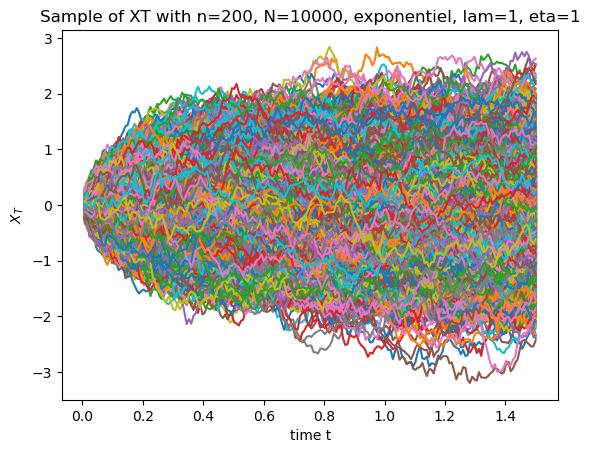

In [33]:
plot_sample(sample=sample_XT_Cholesky(lam=1, eta=1, pre=True)[0], title=f"Sample of XT with n={n}, N={repeat}, exponentiel, lam=1, eta=1")

X_T: mean=0.008 var=3.493 (3.464)
IC(95%) = [-0.028, 0.045] 



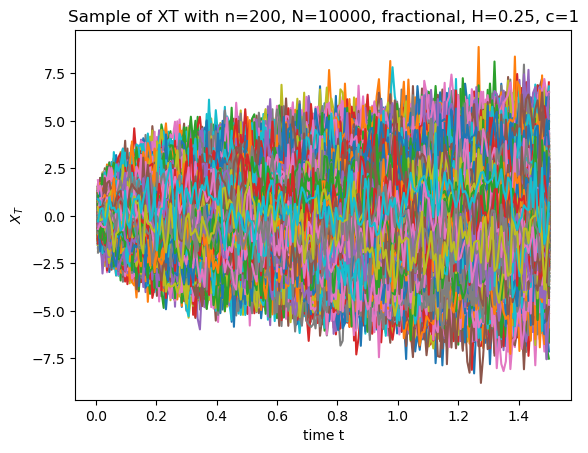

In [35]:
plot_sample(sample=sample_XT_frac(H=0.25, c=1, pre=True)[0], title=f"Sample of XT with n={n}, N={repeat}, fractional, H=0.25, c=1")

## Simulation of $(B_t)_{t\in [0,T]}$

In [36]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1 + np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

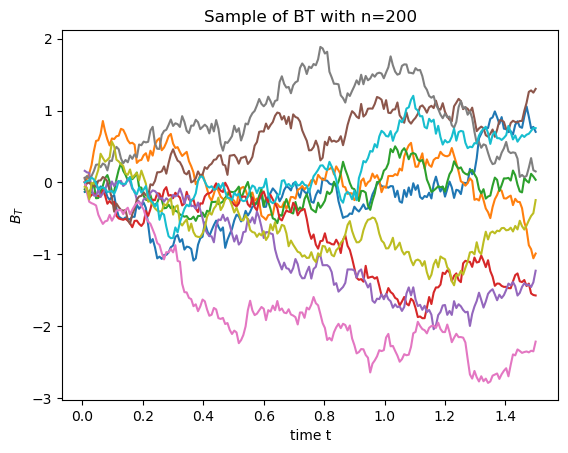

In [37]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

## Simulation of $(\sigma_t)_{t\in [0,T]}$

In [38]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

def Sigma_1(X, ksi=0.5, b=1, lam=1, eta=1, T=1):
    times = np.linspace(0, T, n + 1)[1:]
    return  ksi*np.exp(b*X)/ np.exp(b**2 * eta**2 * (1-np.exp(-2*lam*times))/(2*lam))     

def Sigma_ksit(X, T, vars, alpha0=0.2, alpha1=1, beta=1, a0=1, a1=1):
    tn = np.linspace(0, T, n + 1)[1:]
    return ((a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)) * (alpha0*np.exp(-beta**2*tn)+alpha1*(1-np.exp(-beta**2*tn)))

## Simulation of $(S_t)_{t\in [0,T]}$

In [39]:
def sample_S_exp(rho=0.5, lam=1, eta=1, ksi=0.5, a0=1, T=[1.5], b=1, alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]

    for T_unique in np.unique(T):

        X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
        elif sig=="exp":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_1(X_sample, ksi=ksi, b=b, lam=lam, eta=eta, T=T_unique)))
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        sample.append(sample_S)
        
    if pre:    
        mean = np.mean(sample[0][:, -1])
        var = np.var(sample[0][:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

def sample_S_frac(rho=0.5, H=0.5, c=1, ksi=0.5, a0=1, T=[1.5], alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]
    for T_unique in np.unique(T):
        X_sample, cov = sample_XT_frac(H=H, c=c, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        
        sample.append(sample_S)
        
        if pre:    
            mean = np.mean(sample[0][:, -1])
            var = np.var(sample[0][:, -1])
            demi_width_IC = np.sqrt(var/repeat) * 1.96
            print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
            print("IC(95%%) = [%1.3f, %1.3f] \n" \
            %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

def sample_S_iso(rho=0.5, v=1, epsilon=1, H=0.5, ksi=0.5, a0=1, T=[1.5], alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]
    eta = v*epsilon**(H-0.5)
    lam = -1/epsilon*(H-0.5)
    # print("lam=", lam, "\n eta=", eta)

    for T_unique in np.unique(T):

        X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
    
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        sample.append(sample_S)
        
    if pre:    
        mean = np.mean(sample[0][:, -1])
        var = np.var(sample[0][:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)


S_T: mean=1.003 var=0.188
IC(95%) = [0.995, 1.012] 

(1, 10000, 201)


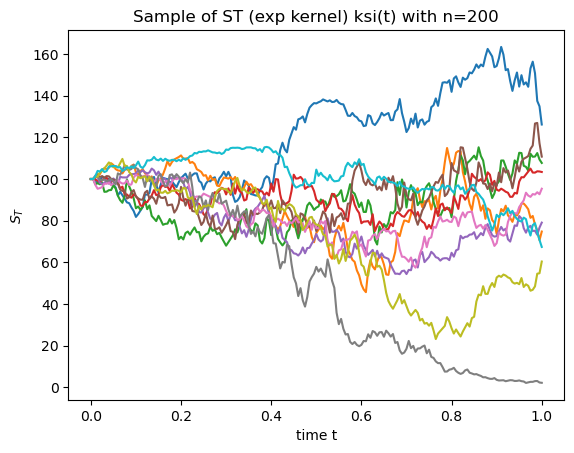

In [40]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=[1], pre=True, sig="ksit")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, 100*sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) ksi(t) with n={n}")
plt.show()


S_T: mean=1.003 var=0.188
IC(95%) = [0.995, 1.012] 

(1, 10000, 201)


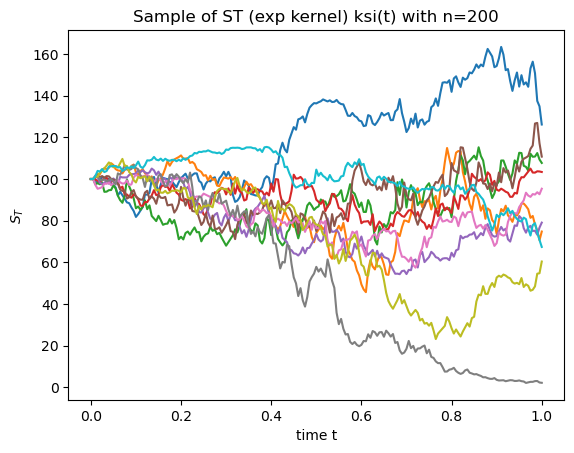

In [41]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=[1], pre=True, sig="ksit")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, 100*sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) ksi(t) with n={n}")
plt.show()


S_T: mean=1.004 var=0.184
IC(95%) = [0.996, 1.013] 

(1, 10000, 201)


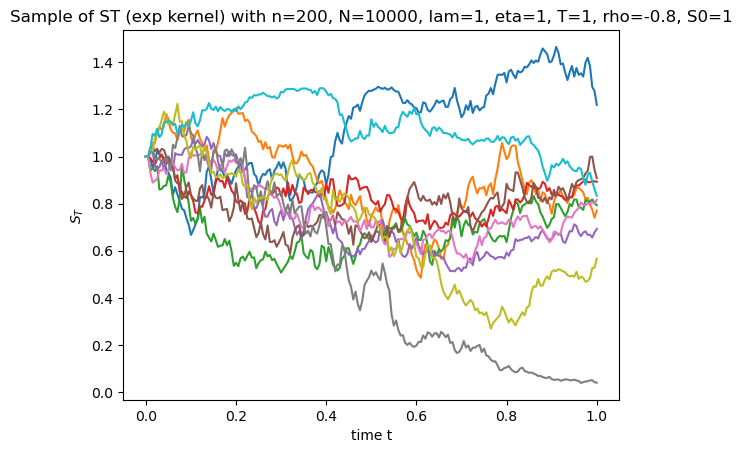

In [44]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=[T], pre=True, sig="poly")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}, N={repeat}, lam=1, eta=1, T={T}, rho=-0.8, S0=1")
plt.show()


S_T: mean=1.003 var=0.176
IC(95%) = [0.994, 1.011] 

(1, 10000, 201)


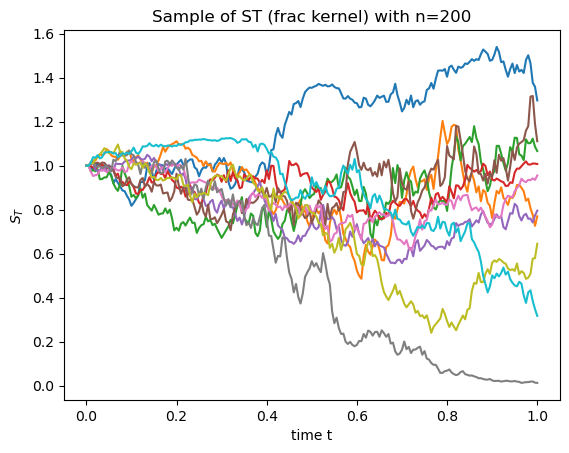

In [42]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=[T], pre=True, sig="ksit")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()


## Least Squares Optimizer

In [154]:
%%time
# Here we calibrate using scipy.optimize for plural slices
from scipy.optimize import least_squares


def loss_1(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
        
    if kernel=="iso":
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
        
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
    
    if kernel=='ksit':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
        
    if kernel=='ksit_frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
        
    if kernel=='ksit_iso':
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], alpha0=x[4], alpha1=x[5], beta=x[6], a0=x[7], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i] for i in range(len(y))])

def loss_2(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp( T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=="iso":
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
    
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
        
    if kernel=='ksit':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_iso':
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], alpha0=x[4], alpha1=x[5], beta=x[6], a0=x[7], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i] for i in range(len(y))]) * np.exp(-0.5*T)

def loss_3(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp( T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=="iso":
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
    
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
        
    if kernel=='ksit':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_iso':
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], alpha0=x[4], alpha1=x[5], beta=x[6], a0=x[7], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([(np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i])/np.sqrt(vega[i]) for i in range(len(y))])

def calibration(Ks, y, S0, T, kernel="frac", loss=loss_1):
    if kernel == "frac":
        x0 = np.array([-0.7, 0.25, 0.5, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 2])
    elif kernel=="exp":
        x0=np.array([-0.75, 1, 1, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 5, 5, 3, 3])
    elif kernel=="iso":
        x0=np.array([-0.75, 1, 1/52, 0.25, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0], [-0.5, 1.5, 1, 1, 3, 3])
    elif kernel=="exp1":
        x0=np.array([-0.75, 1, 1, 0.2, 1])
        bounds=([-1, 0, 0, 0, -1], [-0.5, 5, 5, 3, 3])
    elif kernel=="ksit":
        x0=np.array([-0.75, 1, 1, 0.1, 0.4, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0], [-0.5, 5, 5, 2, 5, 10, 3])
    elif kernel=="ksit_frac":
        x0=np.array([-0.75, 0.25, 0.5, 0.1, 0.4, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 5, 10, 3])    
    elif kernel=="ksit_iso":
        x0=np.array([-0.75, 1, 1/52, 0.25, 0.2, 0.2, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0, 0], [-0.5, 1.5, 1, 1, 2, 5, 10, 3])
    
    return least_squares(loss, x0, bounds=bounds, args=(Ks, y, S0, T, kernel), ftol=1e-8, xtol=1e-8, gtol=1e-8, verbose=1)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.4 µs


In [ ]:
def test_implied_vol(S0, T, Ks, call_models, vol_markets, vol_ask, vol_bid, loss_type="1", model="frac"):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vol_models = np.array([implied_volatility_call_bisection(C=call_models[i], S=S0[i], K=Ks[i], T=T[i], r=0) for i in range(len(Ks))])
    # vol_markets = np.array([implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))])

    ax.plot(np.log(Ks/S0), vol_models, label="model")
    ax.scatter(np.log(Ks/S0), vol_markets, label="market", s=0.4, c="red")
    ax.scatter(np.log(Ks/S0), vol_ask, label="ask", s=0.4, c="green")
    ax.scatter(np.log(Ks/S0), vol_bid, label="bid", s=0.4, c="black")
    
    ax.set_xlabel('K/S')
    ax.set_ylabel('Implied volatility')
    ax.set_title(f"loss type: loss{loss_type}, model: {model}, T={int(T[0]*365)}")

    plt.legend(loc='best')

    plt.show()
    
    loss_MSE = np.mean((vol_markets-vol_models)**2)
    print("Mean squared error:{:.3g}".format(loss_MSE))
  

In [ ]:
# Ks=np.arange(80,122,2)
# y = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))])

# res = calibration(Ks, y, S0=100, T=1.5, loss=loss_1)
# print(res)

# params = res.x

# call_markets = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))]) 
# call_models= np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]) for i in range(len(Ks))])  
# test_implied_vol(S0=100, T=1.5, Ks=Ks, call_models=call_models, call_markets=call_markets) 

### Calibration with 1 unique maturity

In [101]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days)/365.0)

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print("All maturities: \n", 365* np.unique(np.sort(data["T"].to_numpy())))

T = 49/365
print("Chosen maturity:", T*365)
data = data[data['T']==T]
S0 = data['S0'].to_numpy()[0] 
data = data[data['S0']==S0]
data = data[np.abs((data["K"]-S0)/S0)<0.07]

Ks = data['K'].to_numpy()
S0s = [S0]*len(Ks)
Ts = [T]*len(Ks)
call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()
print("Number of points:", len(Ks) )
call_ask = data['ask_1545'].to_numpy()
call_bid = data['bid_1545'].to_numpy()

vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])


All maturities: 
 [  14.   49.   77.  105.  140.  168.  196.  231.  259.  287.  322.  350.
  378.  469.  658.  840. 1568. 1932.]
Chosen maturity: 49.0
Number of points: 69


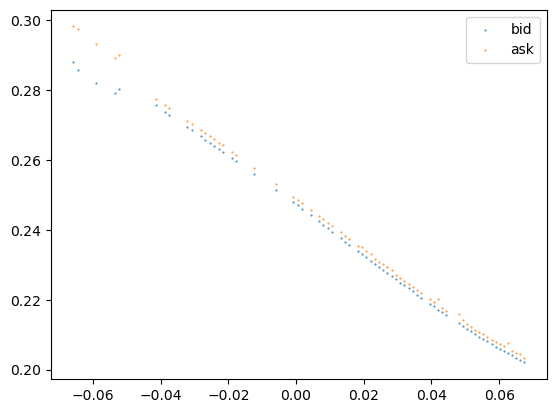

In [102]:
plt.scatter(np.log(Ks/S0), vol_bid, label="bid", s=0.2)
plt.scatter(np.log(Ks/S0), vol_ask, label="ask", s=0.2)
plt.legend()

In [103]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3)
params_frac = res.x
print(params_frac)

`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 4.1014e+01, final cost 1.2562e-03, first-order optimality 1.14e-05.
[-0.77451535  0.41383299  0.80044905  0.26382927  0.46948373]


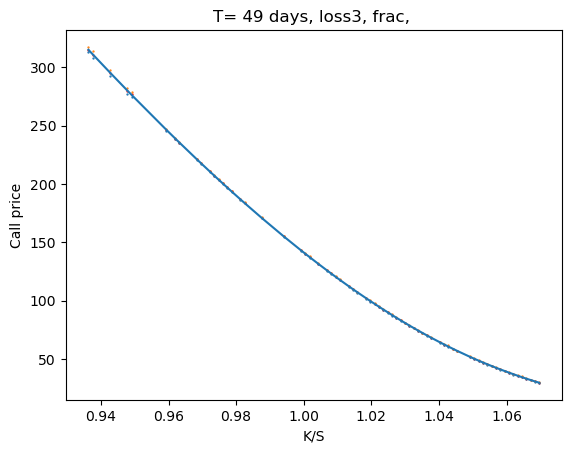

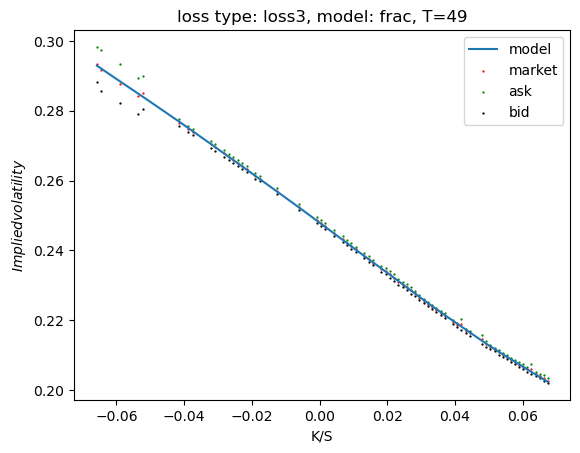

Mean squared error:8.89e-08


In [104]:
params = params_frac
ST = S0*sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[0,:,-1]

output_str = f"rho={params[0]:.3f}, H={params[1]:.6f}, c={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]:.3f}"

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss3, frac, ")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, loss_type=3)    

In [105]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params_exp = res.x

`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 5.0831e+01, final cost 1.1308e-03, first-order optimality 3.82e-05.


rho=-0.746, lam=0.975978, eta=1.171, ksi=0.266, a0=0.494 
[-0.74649     0.9759777   1.17053973  0.26627748  0.49360812]


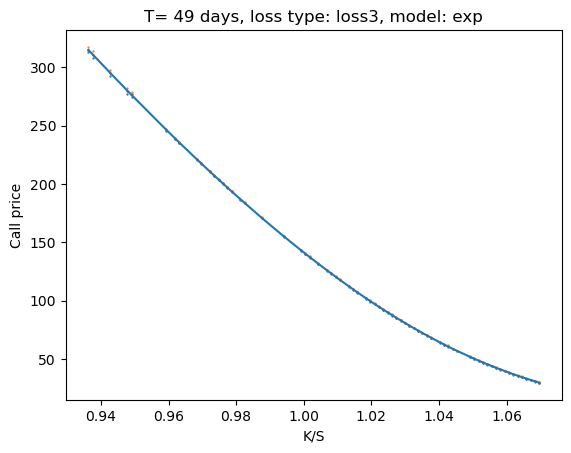

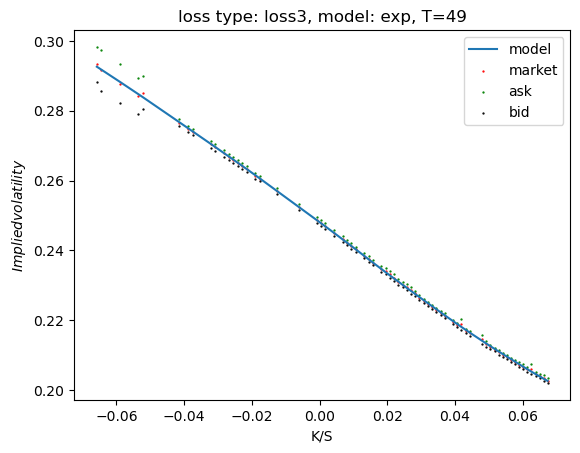

Mean squared error:7.99e-08


In [106]:
params = params_exp
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]:.3f} ")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: exp")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="exp", loss_type=3)    

In [107]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="iso")
params_iso = res.x 

`ftol` termination condition is satisfied.
Function evaluations 81, initial cost 6.0687e+01, final cost 1.1308e-03, first-order optimality 3.87e-05.


rho=-0.746, lam=0.977, eta=1.292, ksi=0.266, a0=0.5446437093573119 
[-0.74649465  0.96895793  0.16119632  0.34252411  0.26627706  0.54464371]


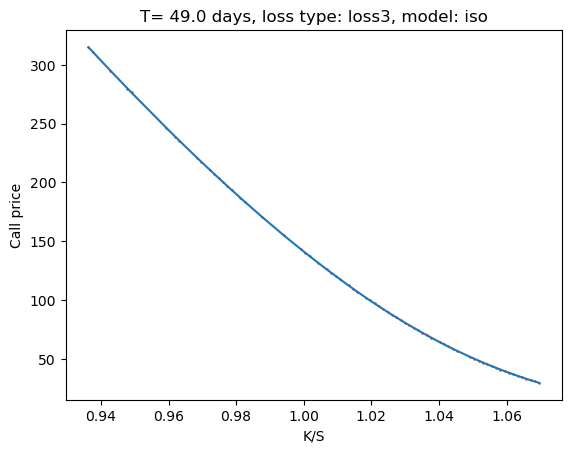

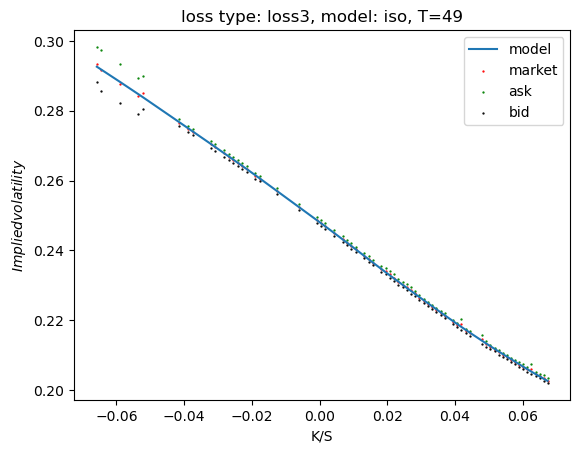

Mean squared error:7.99e-08


In [108]:
params = params_iso

eta = params[1]*params[2]**(params[3]-0.5)
lam = -(params[3]-0.5)/params[2]
print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
print(params)
ST = S0*sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], ksi=params[4], a0=params[5])[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T*365} days, loss type: loss3, model: iso")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="iso", loss_type=3)   

In [109]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp1")
params_exp1 = res.x

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.8777e+01, final cost 3.6627e-03, first-order optimality 1.59e-06.


rho=-0.841, lam=0.000240, eta=1.349, ksi=0.276, b=1.307 
[-8.41315185e-01  2.40315138e-04  1.34896207e+00  2.75633053e-01
  1.30662535e+00]


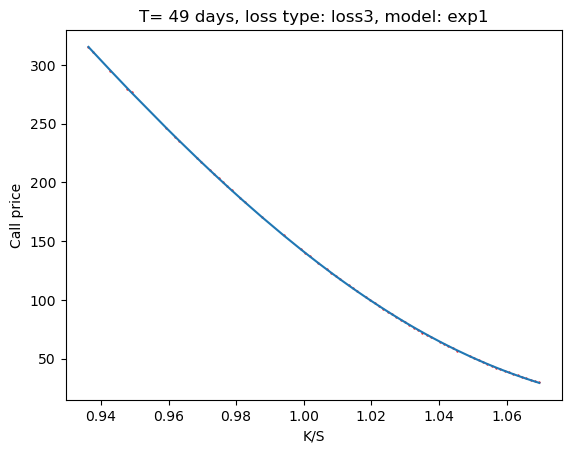

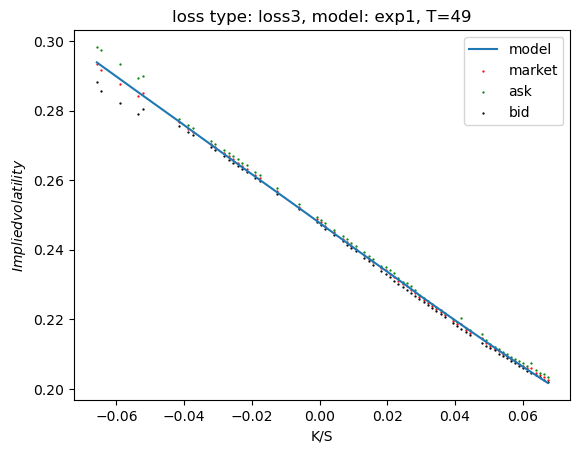

Mean squared error:2.6e-07


In [110]:
params = params_exp1
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, b={params[4]:.3f} ")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], b=params[4], sig="exp")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: exp1")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="exp1", loss_type=3)    

In [111]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params_ksit = res.x

`ftol` termination condition is satisfied.
Function evaluations 94, initial cost 1.0958e+02, final cost 1.1064e-03, first-order optimality 1.47e-05.


rho=-0.746, lam=0.000046, eta=1.177, alpha0=0.247, alpha1=0.353, beta=1.772, a0=0.533
[-7.46185835e-01  4.62670788e-05  1.17691339e+00  2.46774814e-01
  3.53367276e-01  1.77240688e+00  5.32716758e-01]


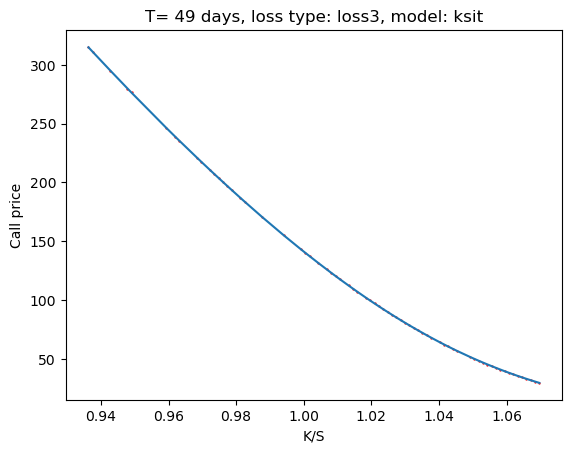

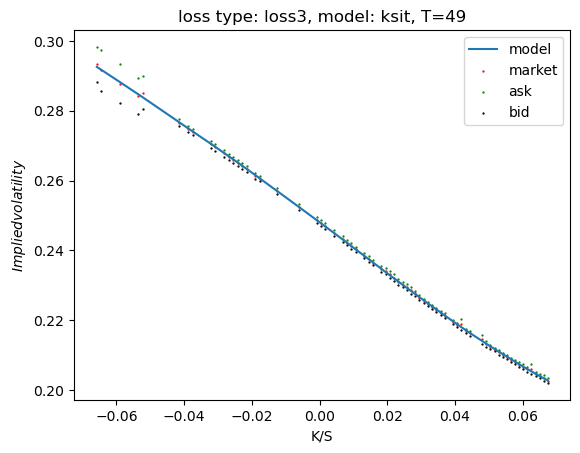

Mean squared error:7.74e-08


In [112]:
params = params_ksit
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: ksit")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="ksit", loss_type=3)    

In [116]:
# res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit_frac")
# params_ksit_frac = res.x

`ftol` termination condition is satisfied.
Function evaluations 44, initial cost 7.7298e+01, final cost 2.5728e-03, first-order optimality 2.84e-05.
[-0.69490232  0.33052476  0.79242916  0.20702923  0.67537716  2.3669152
  0.48865822]


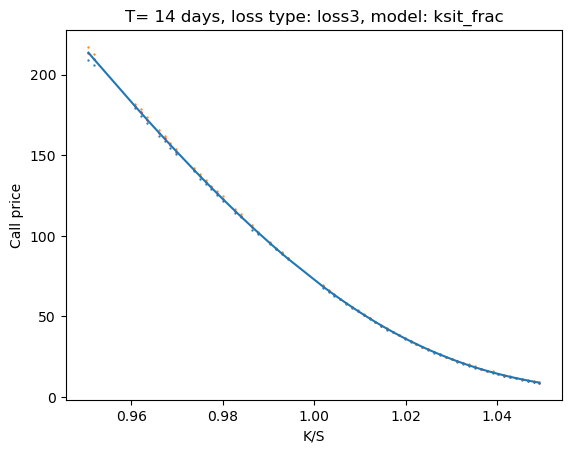

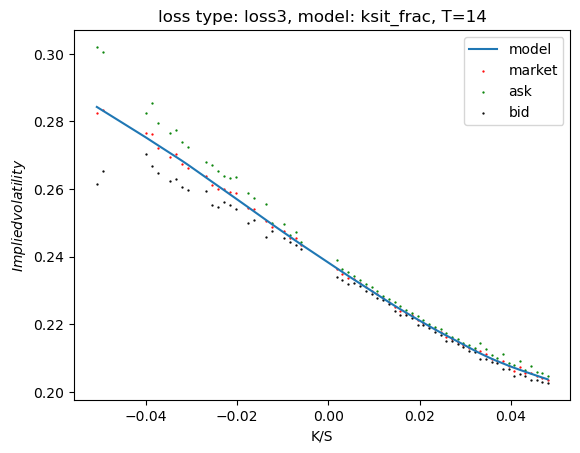

Mean squared error:4.27e-07


In [ ]:
params = params_ksit_frac

ST = S0*sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: ksit_frac")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, loss_type=3, model="ksit_frac")    

In [114]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit_iso")
params_ksit_iso = res.x 

`ftol` termination condition is satisfied.
Function evaluations 185, initial cost 6.0687e+01, final cost 1.1114e-03, first-order optimality 1.94e-05.


rho=-0.746, lam=0.549, eta=1.174, ksi=0.251, a0=0.3141868380918471 
[-0.74585364  0.99788245  0.16373312  0.41008684  0.25103096  0.31418684
  2.08635999  0.5152473 ]


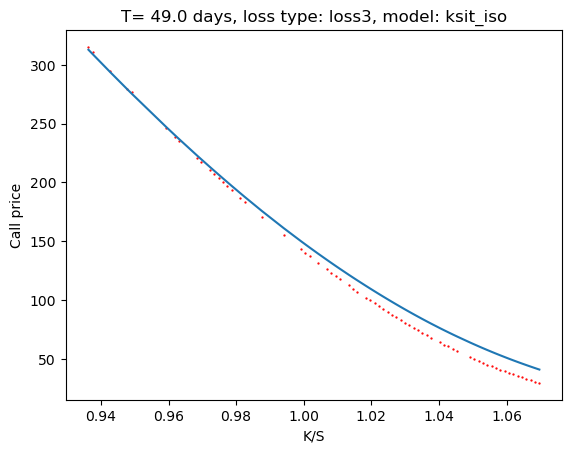

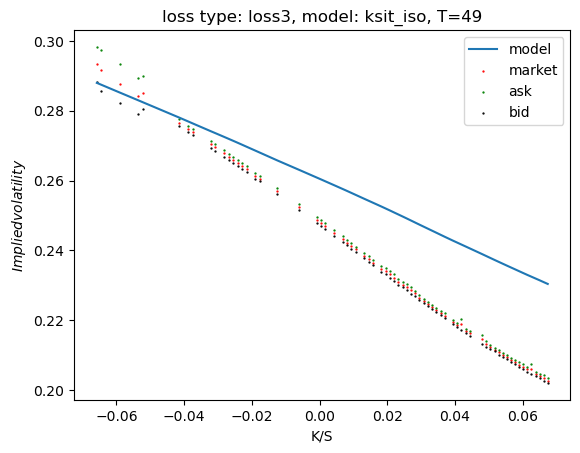

Mean squared error:0.000351


In [115]:
params = params_ksit_iso
eta = params[1]*params[2]**(params[3]-0.5)
lam = -(params[3]-0.5)/params[2]
print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
print(params)
ST = S0*sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], alpha0=params[4], alpha1=params[5], beta=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T*365} days, loss type: loss3, model: ksit_iso")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="ksit_iso", loss_type=3)   

### Calibration over 3 close dates

In [118]:
def dataset(filters={105:0.2, 140:0.25, 168:0.3}, filepath='../data/UnderlyingOptionsEODCalcs_2022-09-02.csv', option_type="C", root="SPX"):
    # Read data
    data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

    # Remove all data not traded in reality
    data = data[data["trade_volume"]>0]

    # Rename some columns according to convention
    data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

    # We only process data for calls here
    data = data[data['option_type']==option_type]
    data = data[data["root"]==root]
    # Calculate the time difference based on the quote date and expiration and convert to days
    data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

    # We use the average of bid and ask for the actual market price
    data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

    print(data["T"].value_counts().sort_index())

    filter_T= list(filters.keys())
    filter_KS = filters
    data = data[(data['T'].isin(filter_T))]

    data["KS"] = data["T"].map(lambda x: filter_KS[x])
    data = data[np.abs((data["K"]-data["S0"])/data["S0"])<data["KS"]]

    S0s = data['S0'].to_numpy()
    Ks = data['K'].to_numpy()
    Ts = data['T'].to_numpy()/365 # If we don't divide T by 365, there will be overflow for calculations of covariance matrix

    call_markets = data['call_markets'].to_numpy()
    # vega = data["vega"].to_numpy()
    # vol_markets = data["implied_volatility"].to_numpy()

    assert len(S0s)==len(Ks)

    print("All maturities:")
    print(data["T"].value_counts().sort_index())
    print("Total points:", len(Ks))

    call_ask = data['ask_1545'].to_numpy()
    call_bid = data['bid_1545'].to_numpy()

    vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
    vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
    vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
    vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])
    return     filter_T, S0s, Ks, Ts, call_markets, call_ask, call_bid, vol_markets, vol_ask, vol_bid, vega


In [121]:
filter_T, S0s, Ks, Ts, call_markets, call_ask, call_bid, vol_markets, vol_ask, vol_bid, vega = dataset()


14      134
49      173
77       69
105      81
140      57
168      48
196      41
231      14
259      17
287      31
322       3
350      10
378      19
469      29
658       7
840       2
1568      2
1932      2
Name: T, dtype: int64
All maturities:
105    66
140    47
168    41
Name: T, dtype: int64
Total points: 154


In [193]:
def show_vol(params, kernel, layout=(1, len(filter_T)), loss_type=2, print_price=False):
    
    if kernel=="exp":
        print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]:.4f} ")
        ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,:,-1]
    if kernel=="frac":
        print(f"rho={params[0]:.3f}, H={params[1]:.6f}, c={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]:.4f} ")
        ST = sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,:,-1]
    if kernel=="iso":
        eta = params[1]*params[2]**(params[3]-0.5)
        lam = -(params[3]-0.5)/params[2]
        print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
        print(params)
        ST = sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], ksi=params[4], a0=params[5])[:,:,-1]
    if kernel=="exp1":
        print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, b={params[4]} ")
        ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], b=params[4], sig="exp")[:,:,-1]    
    if kernel=="ksit":
        print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
        ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
    
    i=1
    plt.figure(1, figsize=(6*layout[1],6*layout[0]))
    for T_view in filter_T:
        T_view = T_view/365


        S0_bis=S0s[np.array(Ts)==T_view]
        T_bis=Ts[np.array(Ts)==T_view]
        Ks_bis=Ks[np.array(Ts)==T_view]              
        call_models_bis=call_models[np.array(Ts)==T_view]
        vol_markets_bis=np.array(vol_markets)[np.array(Ts)==T_view]
        vol_ask_bis = np.array(vol_ask)[np.array(Ts)==T_view]
        vol_bid_bis = np.array(vol_bid)[np.array(Ts)==T_view]
        
        plt.subplot(layout[0], layout[1], i)
        i = i+1

        vol_models = np.array([implied_volatility_call_bisection(C=call_models_bis[i], S=S0_bis[i], K=Ks_bis[i], T=T_bis[i], r=0) for i in range(len(Ks_bis))])

        plt.plot(np.log(Ks_bis/S0_bis), vol_models, label="model")
        plt.scatter(np.log(Ks_bis/S0_bis), vol_markets_bis, label="market", s=0.4, c="red")
        plt.scatter(np.log(Ks_bis/S0_bis), vol_ask_bis, label="ask", s=0.4, c="green")
        plt.scatter(np.log(Ks_bis/S0_bis), vol_bid_bis, label="bid", s=0.4, c="black")
        
        plt.xlabel('K/S')
        plt.ylabel('$Implied volatility$')
        plt.title(f"loss type: loss{loss_type}, model: {kernel}, T={int(T_bis[0]*365)}")

        plt.legend(loc='best')
        loss_MSE = np.mean((vol_markets_bis-vol_models)**2)
        print("Mean squared error:{:.3g} for T={:d}".format(loss_MSE, int(T_view*365)))
    vol_models = np.array([implied_volatility_call_bisection(C=call_models[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))])
    loss_MSE = np.mean((vol_markets-vol_models)**2)
    print("Mean squared error:{:.3g} for all".format(loss_MSE))
    plt.show()
        

In [168]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="exp")
params_exp_close_loss2 = res.x

`ftol` termination condition is satisfied.
Function evaluations 70, initial cost 1.4638e+05, final cost 1.6055e+02, first-order optimality 5.76e-01.


rho=-0.838, lam=3.547049, eta=2.576, ksi=0.302, a0=0.3382 
Mean squared error:0.00114 for T=14
Mean squared error:0.000216 for T=49
Mean squared error:4.34e-06 for T=105
Mean squared error:2.83e-06 for T=140
Mean squared error:0.000366 for all


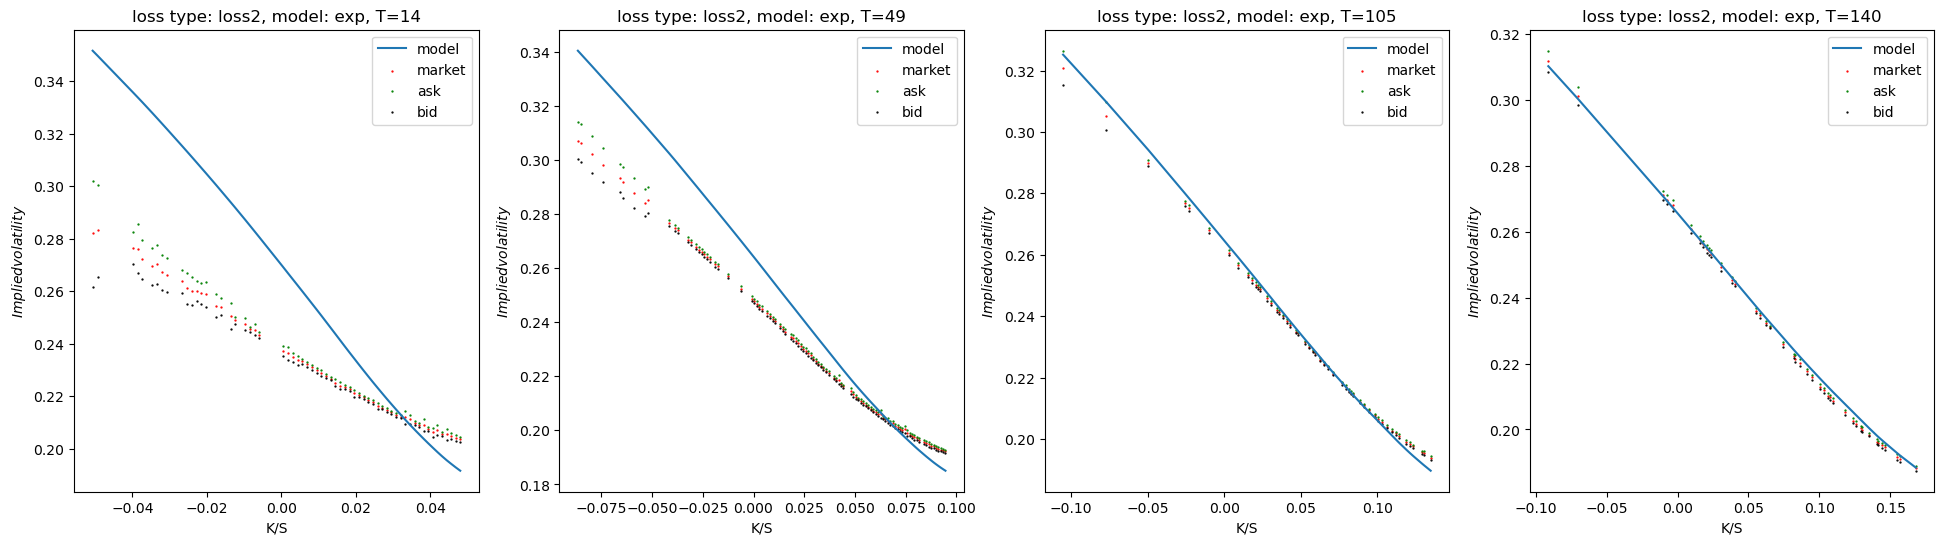

In [194]:
show_vol(params=params_exp_close_loss2, loss_type=2, kernel="exp")

In [131]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params_exp_close_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 2.2960e+02, final cost 2.5348e-01, first-order optimality 6.62e-05.


rho=-0.836, lam=3.486115, eta=2.579, ksi=0.302, a0=0.3418 
Mean squared error:7.99e-06


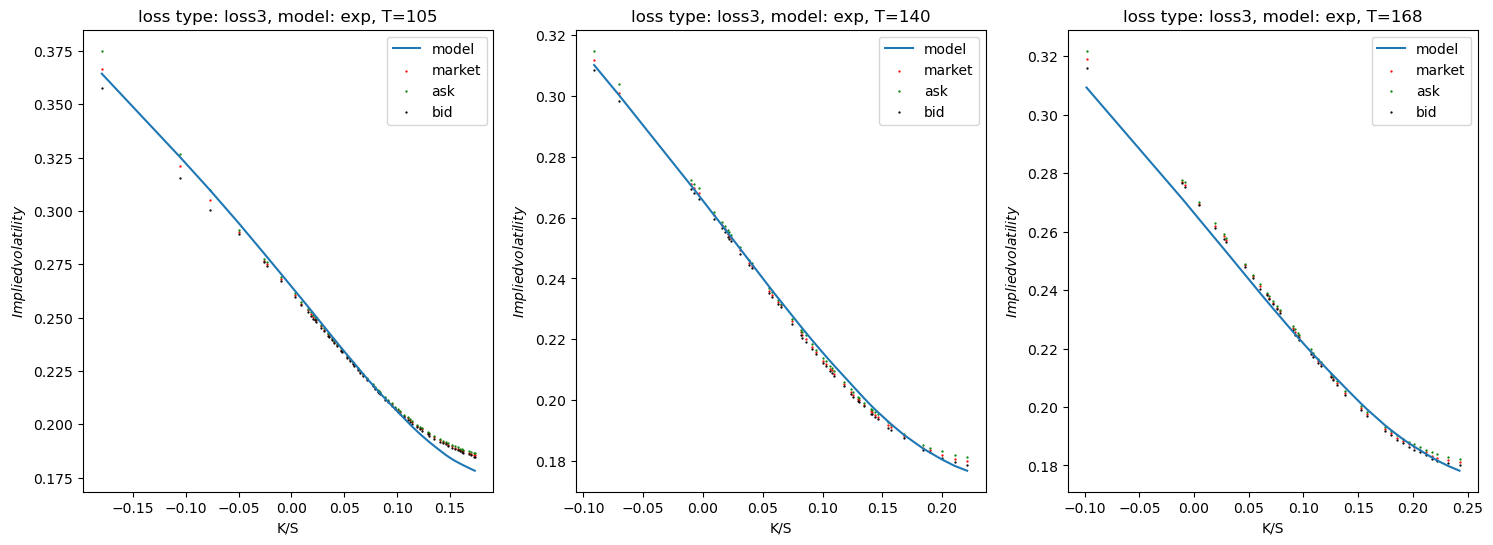

In [180]:
show_vol(params=params_exp_close_loss3, loss_type=3, kernel="exp")

In [133]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="frac")
params_frac_close_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 1.4477e+02, final cost 4.3684e-01, first-order optimality 9.34e-04.


rho=-0.908, H=0.421834, c=1.075, ksi=0.300, a0=0.2670 
Mean squared error:1.15e-05


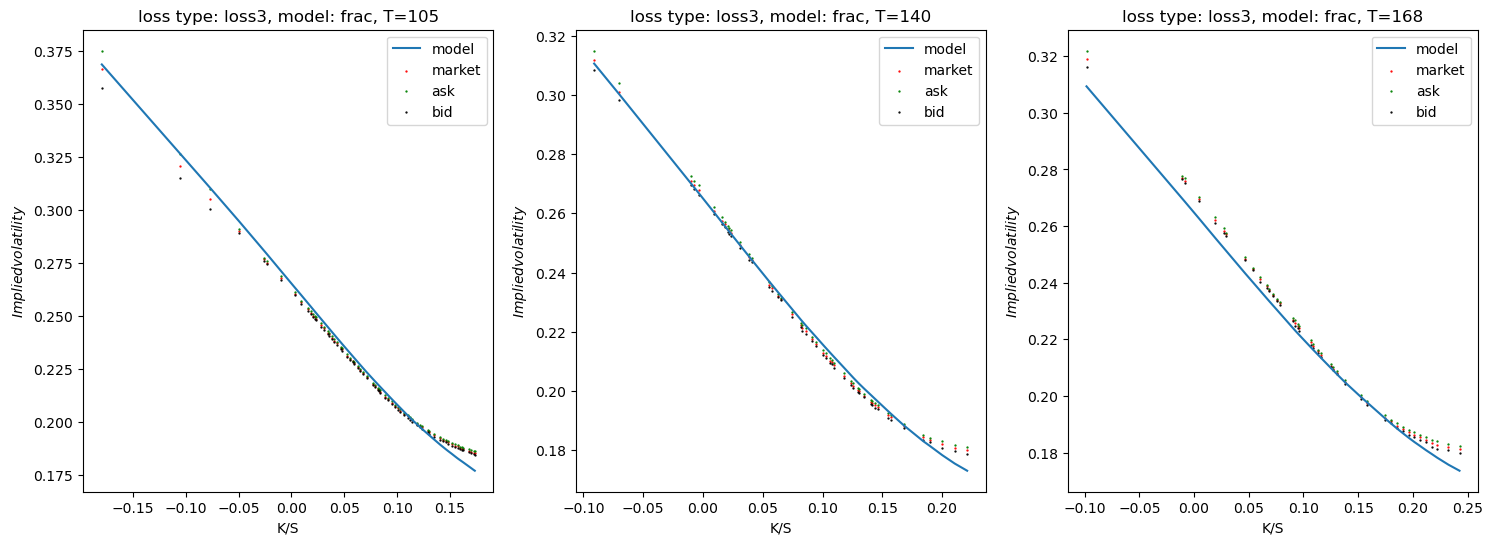

In [181]:
show_vol(params=params_frac_close_loss3, loss_type=3, kernel="frac")

In [136]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="frac")
params_frac_close_loss2 = res.x

rho=-0.914, H=0.419448, c=1.017, ksi=0.300, a0=0.2562 
Mean squared error:1.2e-05


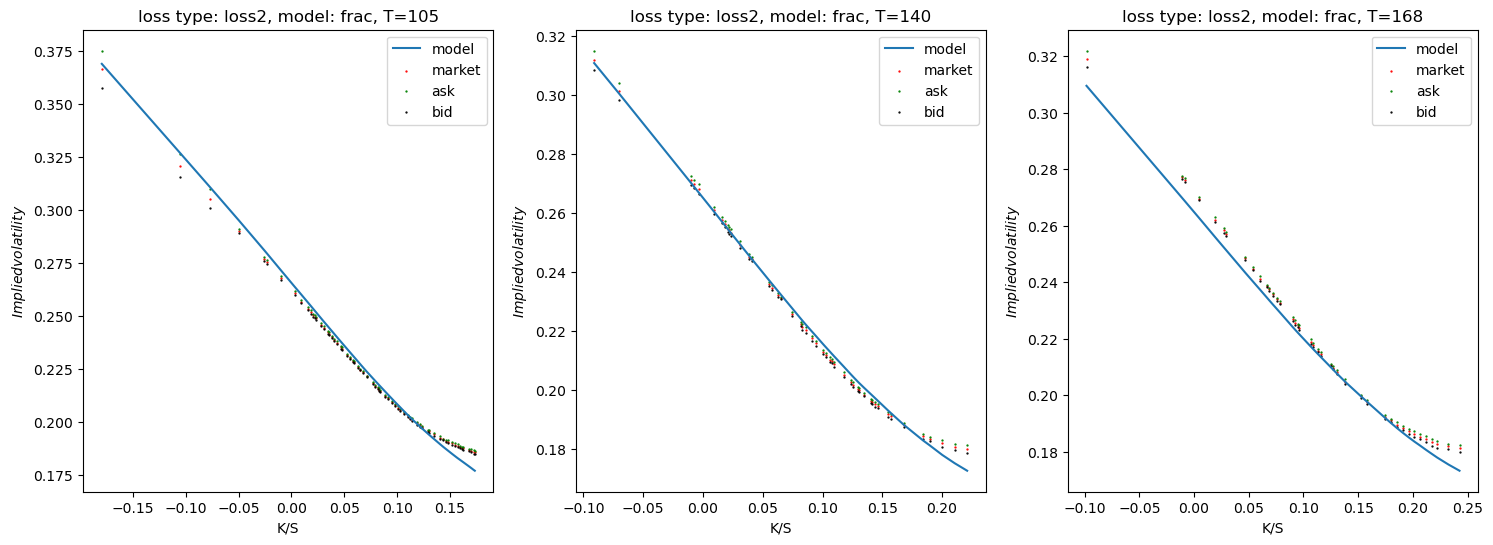

In [182]:
show_vol(params=params_frac_close_loss2, loss_type=2, kernel="frac")

In [139]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="iso")
params_iso_close_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.7978e+02, final cost 2.5348e-01, first-order optimality 1.35e-04.


rho=-0.836, lam=3.492, eta=2.363, ksi=0.302, a0=0.312083971039258 
[-0.83602314  1.10896396  0.09000007  0.185751    0.3023555   0.31208397]
Mean squared error:1.18e-05
Mean squared error:2.98e-06
Mean squared error:7.8e-06


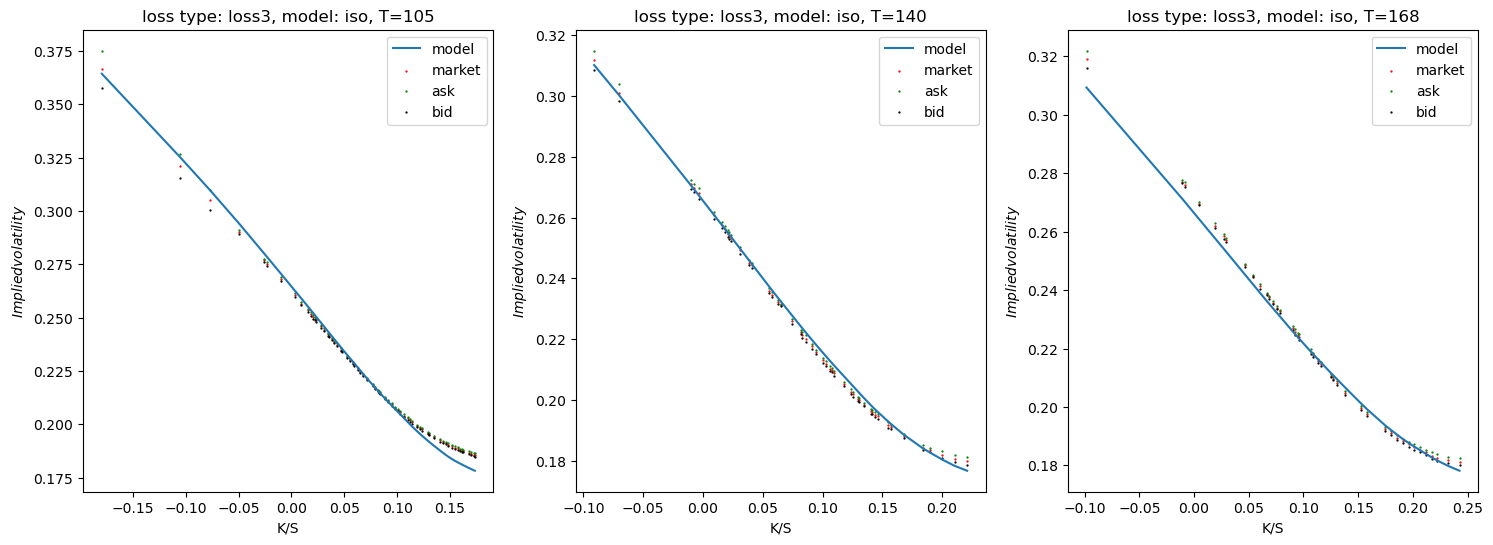

In [143]:
show_vol(params=params_iso_close_loss3, loss_type=3, kernel="iso")

In [155]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="iso")
params_iso_close_loss2 = res.x

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 1.1446e+05, final cost 1.6055e+02, first-order optimality 6.59e-01.


rho=-0.838, lam=3.541, eta=2.397, ksi=0.302, a0=0.314529645943691 
[-0.83750577  1.12653478  0.08760385  0.18982511  0.3023862   0.31452965]
Mean squared error:1.27e-05
Mean squared error:3.05e-06
Mean squared error:7.66e-06


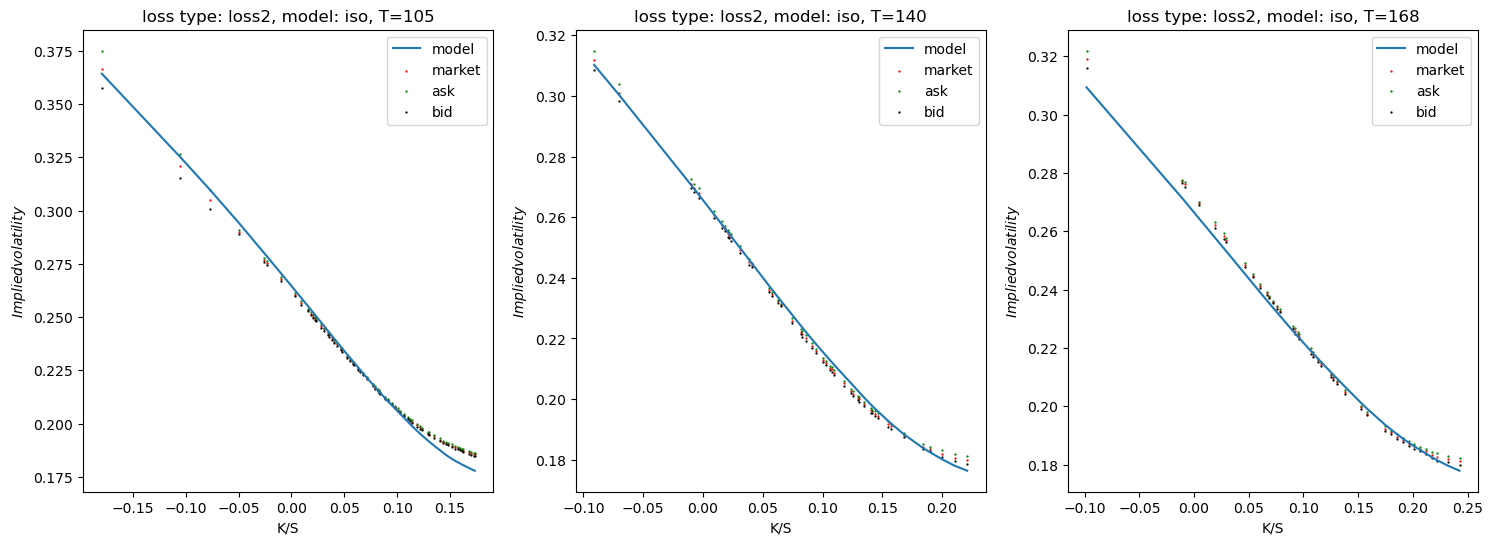

In [156]:
show_vol(params=params_iso_close_loss2, loss_type=2, kernel="iso")

In [158]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp1")
params_exp1_close_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 1.8193e+02, final cost 8.9888e-01, first-order optimality 4.49e-04.


rho=-0.838, lam=5.000000, eta=1.639, ksi=0.309, b=1.321241407882229 
Mean squared error:1.91e-05
Mean squared error:6.01e-06
Mean squared error:3.96e-05


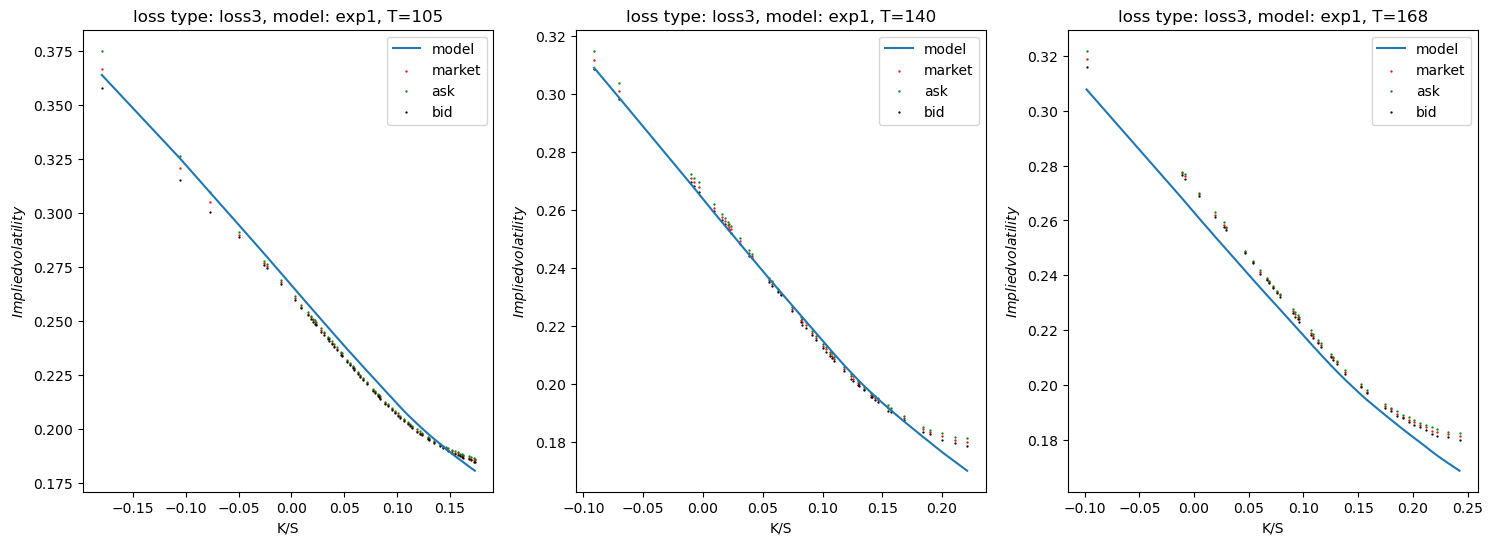

In [160]:
show_vol(params=params_exp1_close_loss3, loss_type=3, kernel="exp1")

In [161]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params_ksit_close_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 203, initial cost 6.8656e+01, final cost 9.6883e-02, first-order optimality 8.24e-05.


rho=-0.818, lam=1.024405, eta=1.047, alpha0=0.266, alpha1=5.000, beta=0.192, a0=0.518
Mean squared error:6.25e-06
Mean squared error:1.83e-06
Mean squared error:4.65e-06


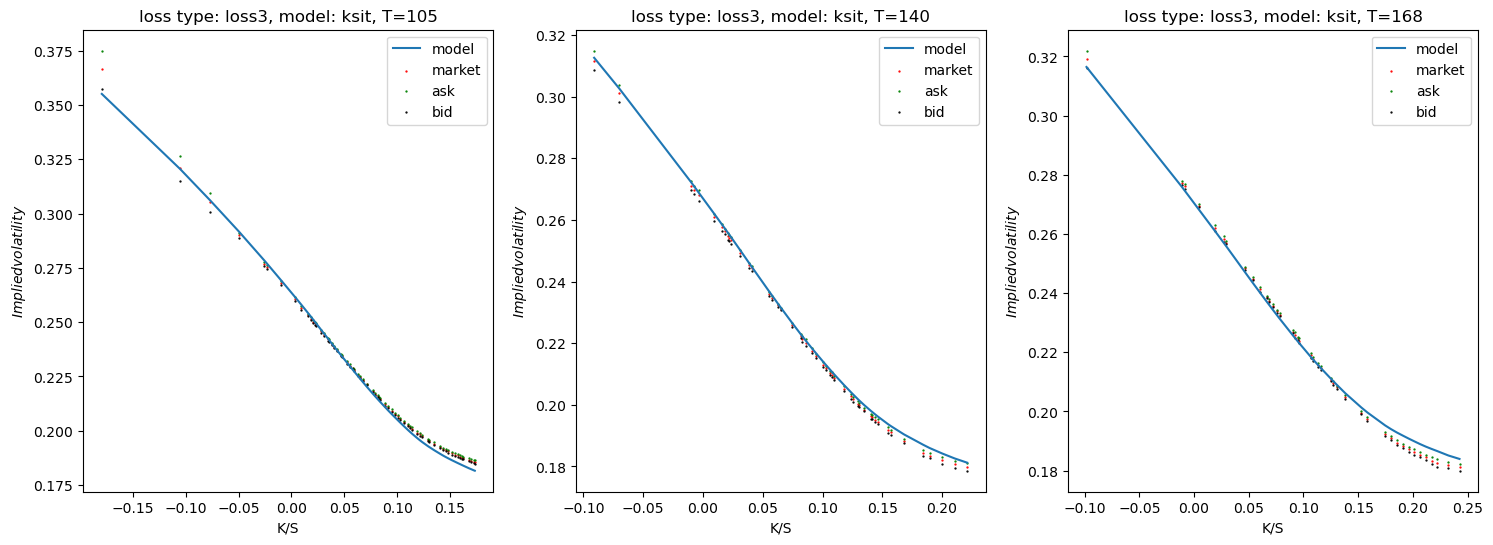

In [165]:
show_vol(params=params_ksit_close_loss3, loss_type=3, kernel="ksit")

### Calibration with larger range of T

In [183]:
filter_T, S0s, Ks, Ts, call_markets, call_ask, call_bid, vol_markets, vol_ask, vol_bid, vega = dataset(filters={14:0.05, 49:0.10, 105:0.15, 140:0.20})

14      134
49      173
77       69
105      81
140      57
168      48
196      41
231      14
259      17
287      31
322       3
350      10
378      19
469      29
658       7
840       2
1568      2
1932      2
Name: T, dtype: int64
All maturities:
14     62
49     96
105    51
140    42
Name: T, dtype: int64
Total points: 251


In [184]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params_exp_larger_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 2.2119e+02, final cost 7.4767e+00, first-order optimality 2.98e-03.


rho=-0.918, lam=5.000000, eta=0.959, ksi=0.259, a0=0.6691 
Mean squared error:0.00038 for T=14
Mean squared error:7.42e-05 for T=49
Mean squared error:8.71e-05 for T=105
Mean squared error:0.000123 for T=140
Mean squared error:0.00016 for all


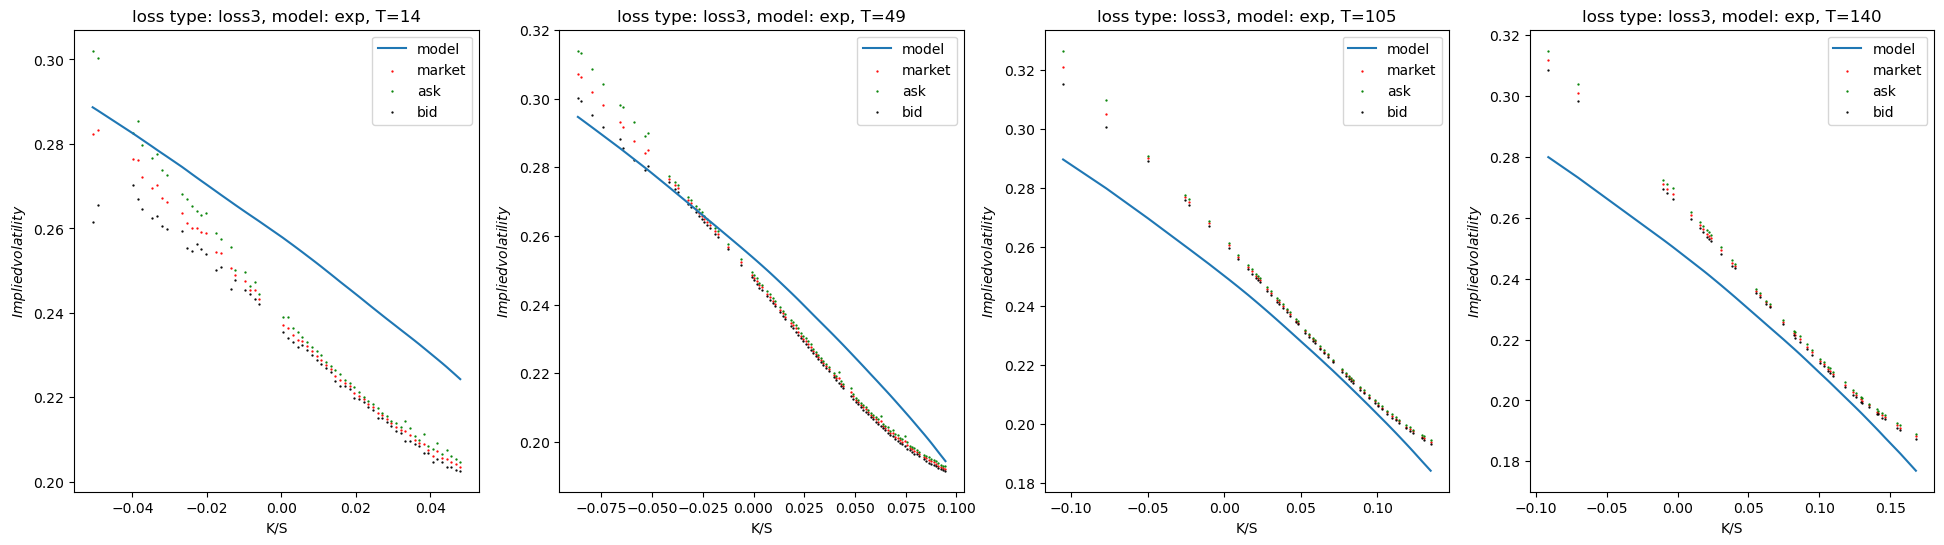

In [195]:
show_vol(params=params_exp_larger_loss3, loss_type=3, layout=(1,4), kernel="exp")

In [190]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="exp")
params_exp_larger_loss2 = res.x

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 1.2820e+05, final cost 1.5486e+03, first-order optimality 1.23e-02.


rho=-0.769, lam=5.000000, eta=1.173, ksi=0.282, a0=0.0000 
Mean squared error:0.000338 for T=14
Mean squared error:1.98e-05 for T=49
Mean squared error:2.36e-05 for T=105
Mean squared error:4.85e-05 for T=140
Mean squared error:0.000104 for all


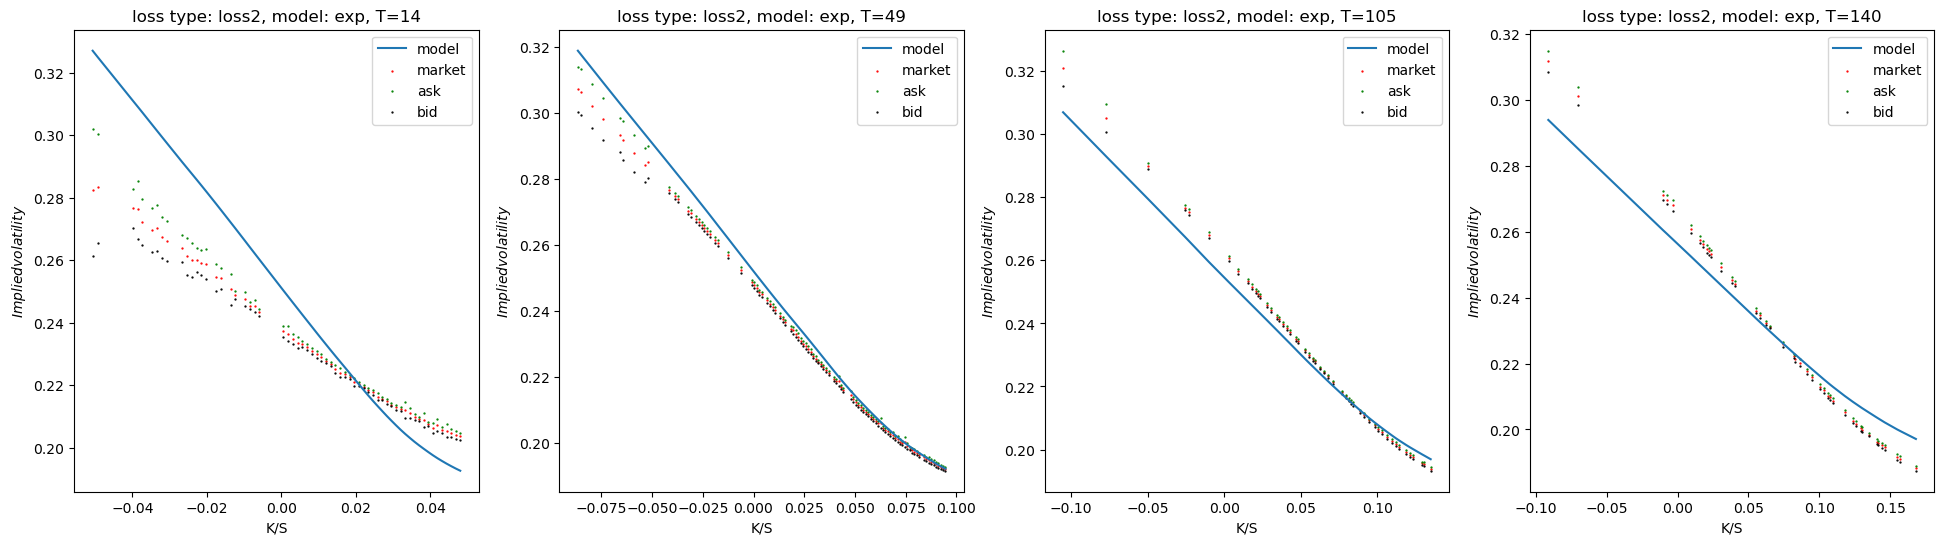

In [196]:
show_vol(params=params_exp_larger_loss2, loss_type=2, layout=(1,4), kernel="exp")

In [201]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="frac")
params_frac_larger_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 1.5548e+02, final cost 4.2411e+00, first-order optimality 4.19e-03.


rho=-0.866, H=0.372331, c=1.133, ksi=0.272, a0=0.1693 
Mean squared error:0.000237 for T=14
Mean squared error:2.17e-05 for T=49
Mean squared error:5.24e-05 for T=105
Mean squared error:8.73e-05 for T=140
Mean squared error:9.21e-05 for all


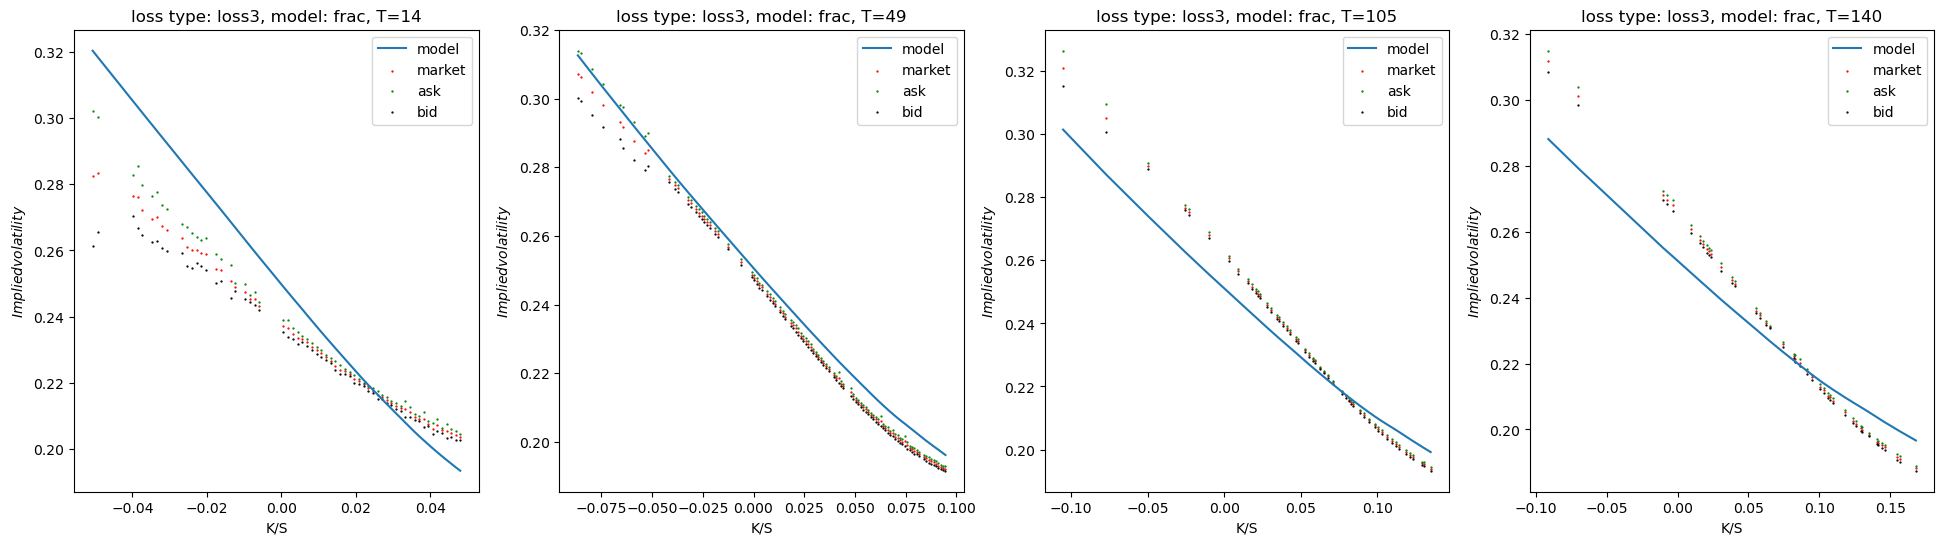

In [213]:
show_vol(params=params_frac_larger_loss3, loss_type=3, layout=(1,4), kernel="frac")

In [202]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="iso")
params_iso_larger_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 2.0994e+02, final cost 3.8436e+00, first-order optimality 4.90e-03.


rho=-0.792, lam=16.130, eta=2.791, ksi=0.267, a0=0.6047448386511194 
[-0.79179667  0.96297822  0.01593872  0.24290787  0.26675182  0.60474484]
Mean squared error:0.000228 for T=14
Mean squared error:5.26e-06 for T=49
Mean squared error:5.18e-05 for T=105
Mean squared error:0.000108 for T=140
Mean squared error:8.68e-05 for all


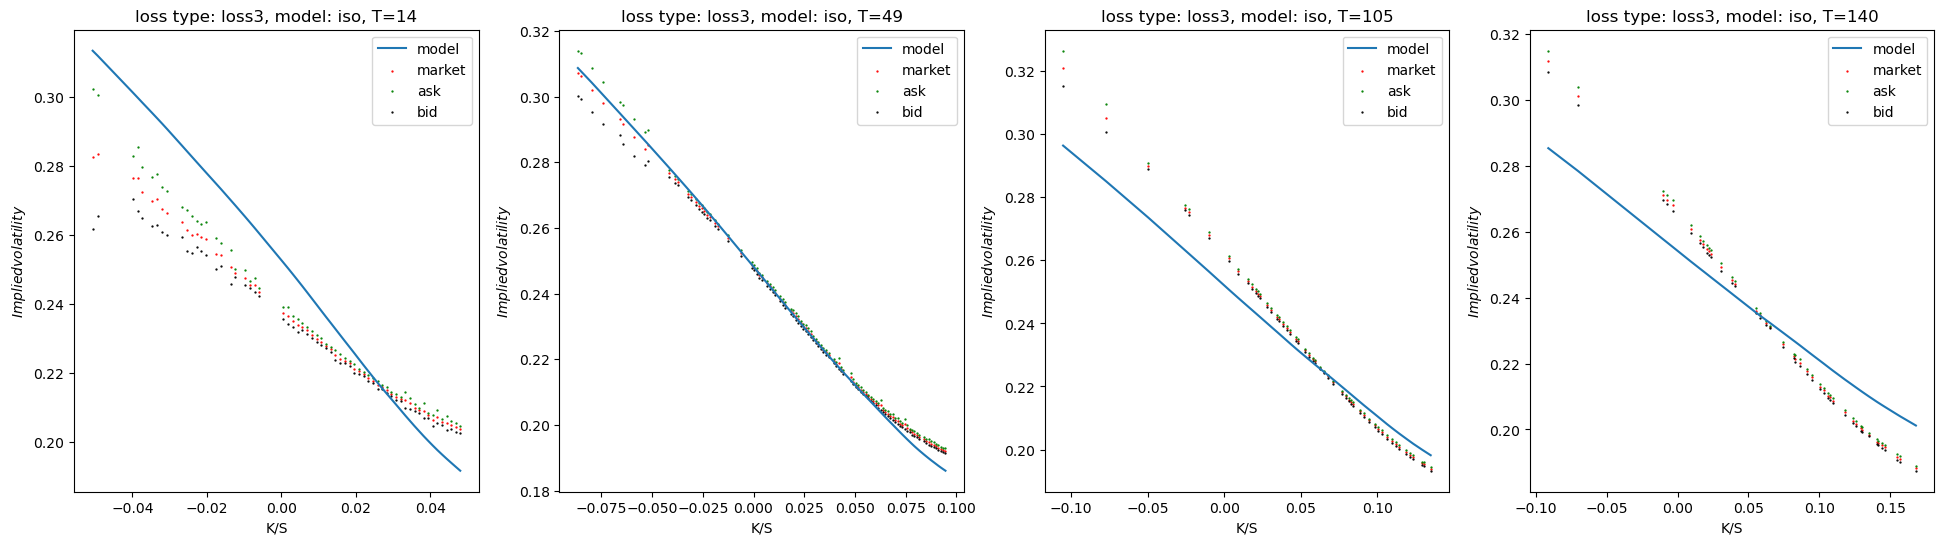

In [206]:
show_vol(params=params_iso_larger_loss3, loss_type=3, layout=(1,4), kernel="iso")

In [203]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp1")
params_exp1_larger_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 1.7193e+02, final cost 9.5016e+00, first-order optimality 7.38e-03.


rho=-1.000, lam=4.999999, eta=1.174, ksi=0.261, b=0.9899087425598713 
Mean squared error:0.000446 for T=14
Mean squared error:0.000122 for T=49
Mean squared error:0.000107 for T=105
Mean squared error:0.000149 for T=140
Mean squared error:0.000204 for all


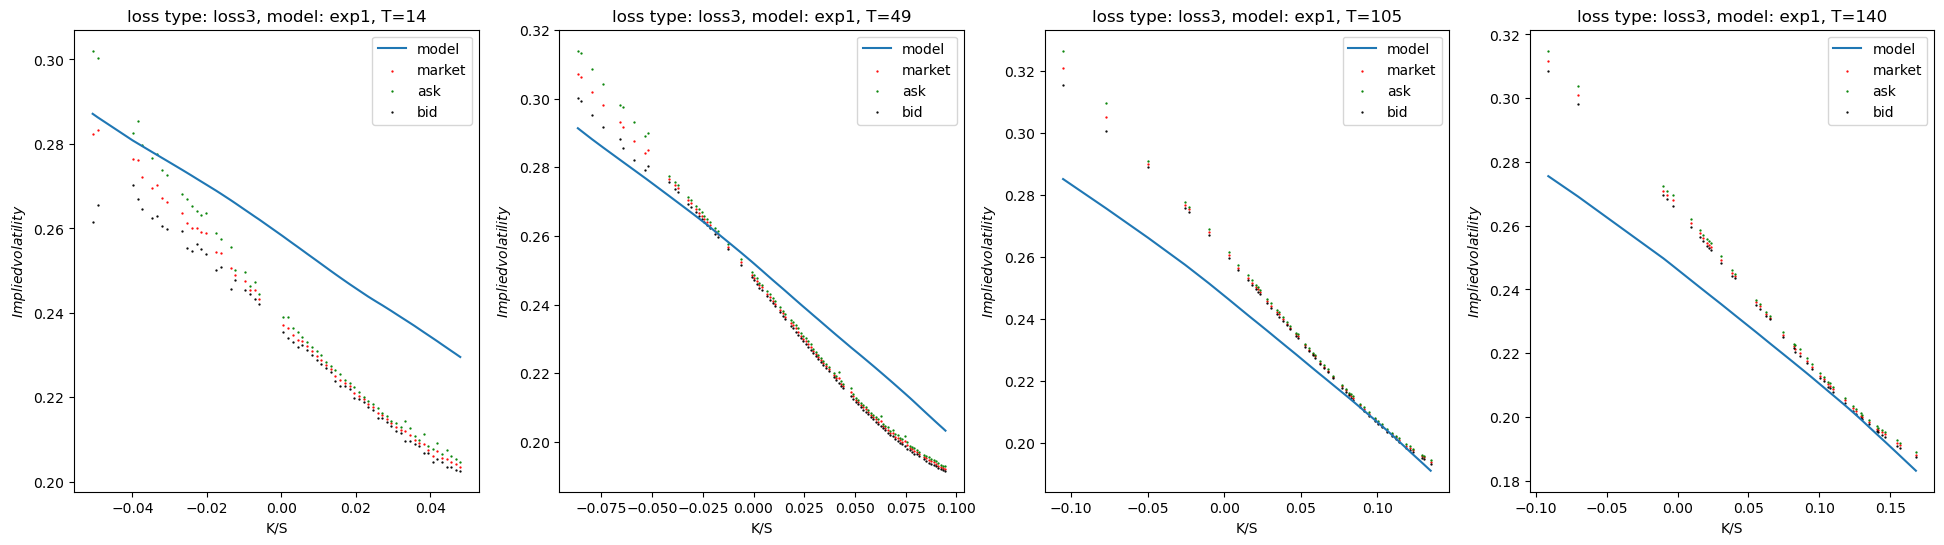

In [207]:
show_vol(params=params_exp1_larger_loss3, loss_type=3, layout=(1,4), kernel="exp1")

In [204]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params_ksit_larger_loss3 = res.x

`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 2.5528e+02, final cost 2.0136e-01, first-order optimality 8.03e-05.


rho=-0.802, lam=1.188607, eta=1.013, alpha0=0.232, alpha1=0.340, beta=2.412, a0=0.509
Mean squared error:8.85e-06 for T=14
Mean squared error:5.46e-06 for T=49
Mean squared error:2.61e-06 for T=105
Mean squared error:6.12e-06 for T=140
Mean squared error:5.83e-06 for all


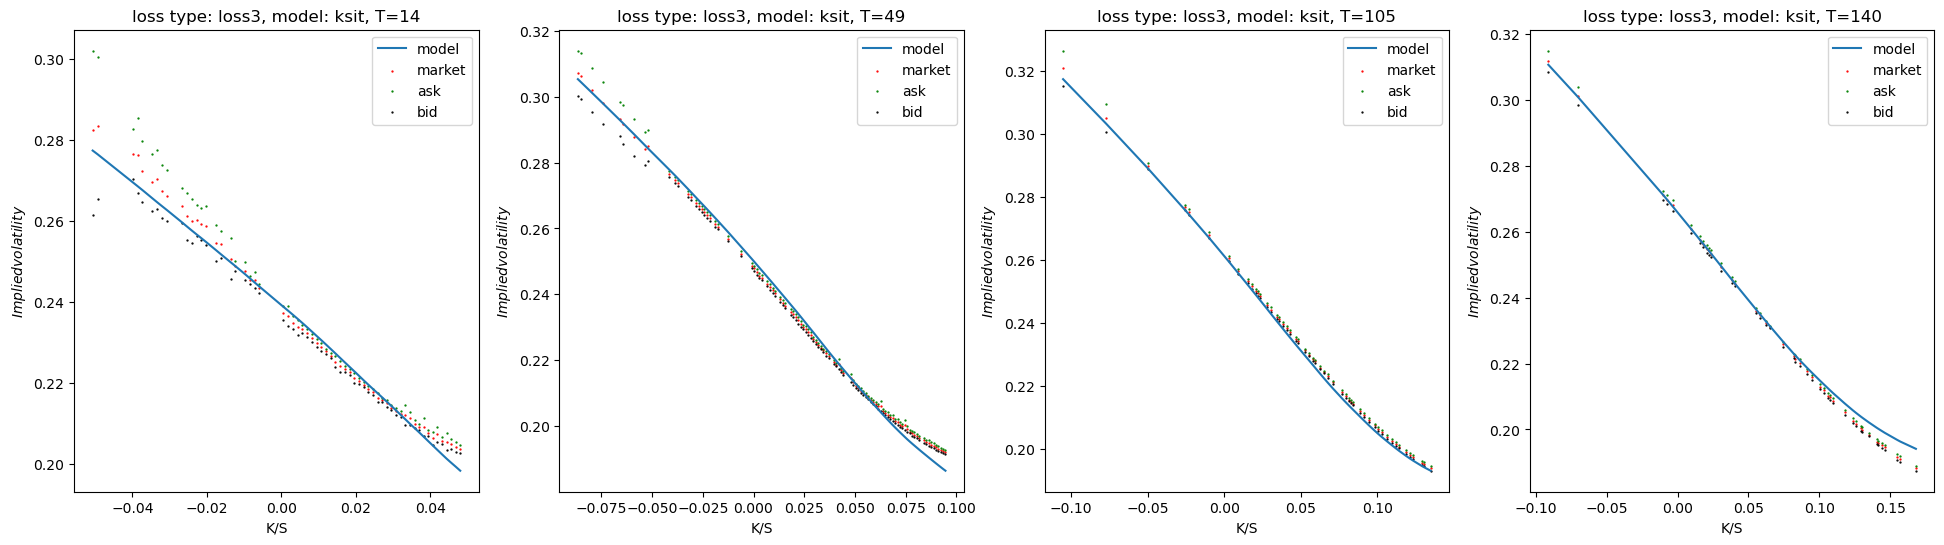

In [209]:
show_vol(params=params_ksit_larger_loss3, loss_type=3, layout=(1,4), kernel="ksit")

In [211]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="ksit")
params_ksit_larger_loss2 = res.x

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 1.1907e+05, final cost 9.7838e+01, first-order optimality 1.02e+00.


rho=-0.805, lam=1.066167, eta=1.001, alpha0=0.230, alpha1=0.340, beta=2.437, a0=0.516
Mean squared error:1.15e-05 for T=14
Mean squared error:5.57e-06 for T=49
Mean squared error:2.46e-06 for T=105
Mean squared error:4.85e-06 for T=140
Mean squared error:6.28e-06 for all


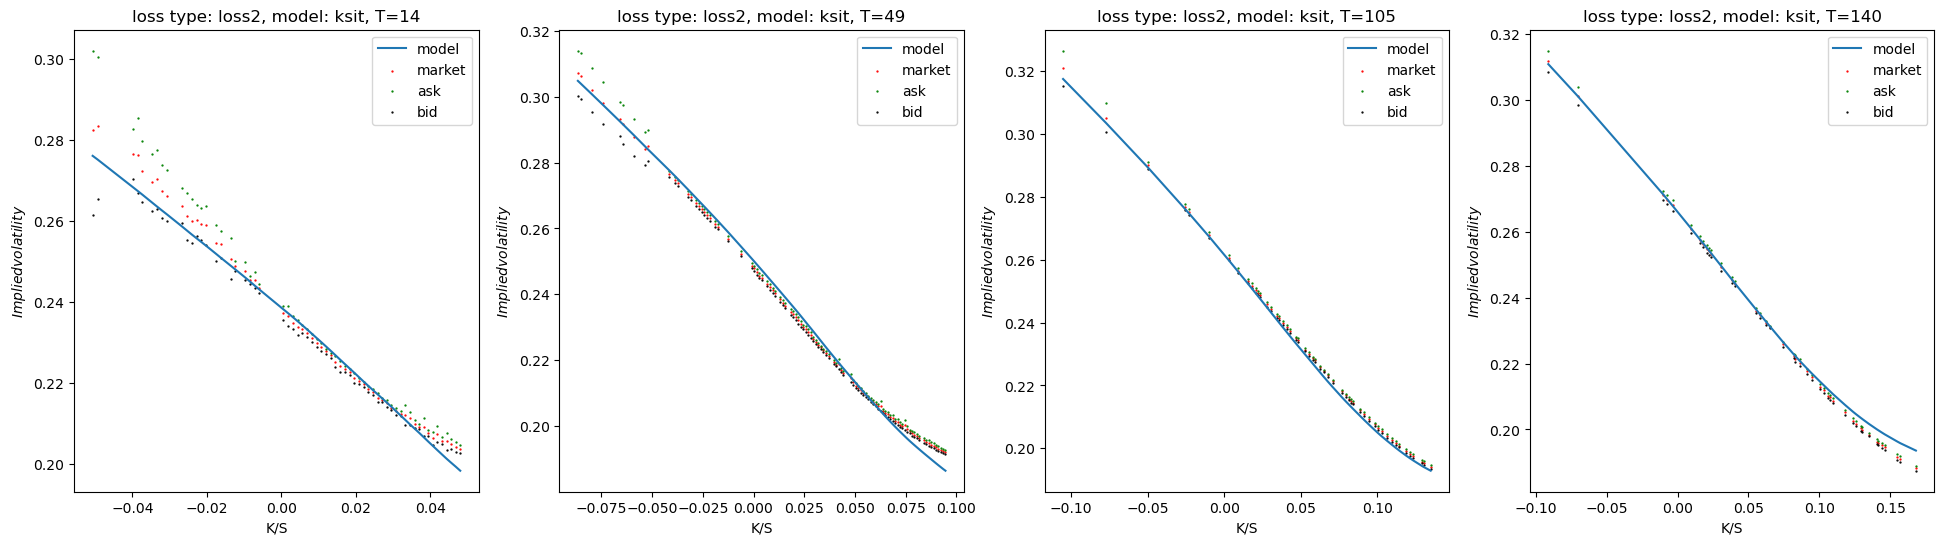

In [212]:
show_vol(params=params_ksit_larger_loss2, loss_type=2, layout=(1,4), kernel="ksit")